In [1]:
import pandas as pd
!pip install shapely

DEPRECATION: pandas 0.23.4 has a non-standard dependency specifier pytz>=2011k. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pandas or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: unyt 2.8.0 has a non-standard dependency specifier numpy>="1.13.0". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of unyt or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
%run ROUTINES/gauss_asym.py

In [3]:
%matplotlib widget

## Load fit info

In [4]:
#df_fits = pd.read_csv('fit_info/fit_sobrevivientes_rho_arm2.csv')

id_halo='198184'
df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_arm1_all_points_HALO{id_halo}_.csv')
df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis = 1)
df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis = 1)

In [5]:
df_fits.tail(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing
11,0.000098,2.473229,0.05,False,1.112708,11.0,0.795264,0.000016,0.865885,3.685717,0.809206,"[1.9908953578160502, 2.001889207208638, 2.2632...",-2.258297,"[1.8612973438596295e-05, 1.774352040443952e-05...",1.466450
12,0.000267,3.279192,0.05,False,0.737979,12.0,1.563677,0.000011,1.173953,1.579154,0.679416,"[1.6953448706846932, 1.8165201697641584, 1.858...",-2.893218,"[1.8239767435661006e-05, 2.5023485805887056e-0...",-0.149711
13,0.000199,1.963932,0.05,False,0.656215,13.0,1.371112,0.000008,1.329517,1.877113,0.662523,"[0.9685879313863149, 1.0255939037611443, 1.085...",-2.258297,"[2.319526892146993e-05, 2.7021902019902427e-05...",-1.304113


In [6]:
params = df_fits.iloc[0] # Para investigar los resultado del fit de un punto, llamamos su fila en el DataFrame

In [7]:
params

amplitude                                                 0.000203444
center                                                        12.4635
delta                                                            0.05
fractured                                                       False
gamma                                                        -2.81577
id_tracing                                                          0
sigma                                                        0.943725
stderr_amplitude                                          1.58359e-05
stderr_center                                                0.072555
stderr_gamma                                                  1.46191
stderr_sigma                                                 0.155144
x                   [10.262399426064238, 10.37397427238432, 10.455...
x_tracing                                                     10.7287
y                   [7.114439416696633e-06, 2.707541376557573e-05,...
y_tracing           

In [8]:
#import numpy as np

# Convertir las columnas 'x' y 'y' de cadenas a arrays numéricos
#params['x'] = np.array(params['x'].split('\\n'), dtype=float)
#params['y'] = np.array(params['y'].split('\\n'), dtype=float)

# Verificar los resultados
#print("X values:", params['x'])
#print("Y values:", params['y'])


In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False


In [10]:
from shapely.geometry import LineString

def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Encuentra el máximo
    x_max, y_max = find_maximum(x_eval, y_eval)

    # Generar la línea horizontal en y = y_max / 2
    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    # Crear LineString para las dos líneas
    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []

    # Si la intersección es un solo punto
    if intersection.geom_type == 'Point':
        points_intercept = [(intersection.x, intersection.y)]
    # Si la intersección es una colección de puntos
    elif hasattr(intersection, 'geoms'):
        points_intercept = [(point.x, point.y) for point in intersection.geoms]
    # Si no hay intersección
    elif intersection.is_empty:
        return {'x_max': x_max, 'y_max': y_max, 'w1': np.nan, 'w2': np.nan}

    # Asegurarse de que hay suficientes puntos de intersección
    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}

def plot_fit_and_widths_dani(params, ax, dx=0.001):
    width_info = find_widths_of_skewed_gaussian_dani(params, dx=dx)

    dict_eval = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = dict_eval['x_eval']
    y_eval = dict_eval['y_eval']

    # Plotea la función ajustada
    ax.plot(x_eval, y_eval, lw=2.5, label='Fitted Function')

    # Máximos y anchos
    ax.axvline(x=width_info['x_max'], color='red', lw=1.5, label='x_max = {:.3f}'.format(width_info['x_max']))
    ax.axhline(y=width_info['y_max'], ls='--', color='k', label='y_max = {:.2e}'.format(width_info['y_max']))
    ax.axhline(y=0.5 * width_info['y_max'], color='green', lw=1.5, label='y_max / 2 = {:.2e}'.format(0.5 * width_info['y_max']))

    # Líneas verticales para w1 y w2
    ax.axvline(x=np.abs(width_info['x_max'] - width_info['w1']), color='magenta', lw=1.5, ls='--', label='w1 = {:.3f}'.format(width_info['w1']))
    ax.axvline(x=np.abs(width_info['x_max'] + width_info['w2']), color='purple', lw=1.5, ls='--', label='w2 = {:.3f}'.format(width_info['w2']))

    # Ajustar etiquetas de los ticks
    xt = ax.get_xticks()
    tick1 = '{:.2f}'.format(np.abs(width_info['x_max'] - width_info['w1']))
    tick2 = '{:.2f}'.format(np.abs(width_info['x_max'] + width_info['w2']))
    xt = np.append(xt, [float(tick1), float(tick2)])

    ax.set_xticks(xt)
    ax.set_xticklabels(xt)

    ax.grid(alpha=0.5, lw=1, ls='--')
    ax.legend(loc='upper left')



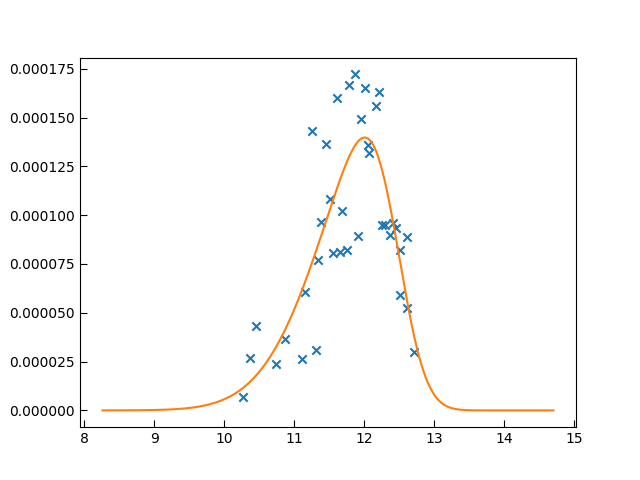

In [11]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

# Graficamos el fit y los puntos con los que se hizo el fit
fig, ax = plt.subplots()
ax.scatter(params.x, params.y, color = 'C0', marker = 'x') # Envoltorio
model_eval = eval_fitted_model_with_given_params(params, dx = 0.01) # Funcion en gauss_asym.py
x_eval = model_eval['x_eval']
y_eval = model_eval['y_eval']
ax.plot(x_eval, y_eval,color = 'C1'); # Fit

## Calculate width of a fit

In [12]:
%run ROUTINES/gauss_asym.py

In [13]:
dx = 0.001 # Discretizacion para mapear la gaussiana

In [14]:
width_info = find_widths_of_skewed_gaussian_dani(params, dx = dx) # Funcion en gauss_asym.py

In [15]:
width_info # Retorna la ubicacion del maximo (x_max, y_max) y el ancho a la izquierda (w1) y a la derecha (w2)

{'x_max': 12.006399426062163,
 'y_max': 0.00013976432022361367,
 'w1': 0.8094347867340286,
 'w2': 0.5354152204209157}

In [16]:
#fig, ax = plt.subplots(figsize=(10,5))
#plot_fit_and_widths(params, ax, dx = dx) # Funcion en gauss_asym.py

In [17]:
# Podemos aplicar find_widths_of_skewed_gaussian() a toda la tabla con la informacion de los parametros 

df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [18]:


df_fits.head(4)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,stderr_sigma,x,x_tracing,y,y_tracing,width_info,x_max,y_max,w1,w2
0,0.000203,12.463550,0.05,False,-2.815769,0.0,0.943725,0.000016,0.072555,1.461911,0.155144,"[10.262399426064238, 10.37397427238432, 10.455...",10.728716,"[7.114439416696633e-06, 2.707541376557573e-05,...",-6.094877,"{'x_max': 12.006399426062163, 'y_max': 0.00013...",12.006399,0.000140,0.809435,0.535415
1,0.000141,11.975673,0.05,False,-3.366697,1.0,1.562937,0.000020,0.178578,3.184783,0.243040,"[9.086654767552309, 9.309088161549216, 9.34395...",9.805195,"[9.727255496254541e-06, 1.563181236322171e-05,...",-4.363276,"{'x_max': 11.269654767553707, 'y_max': 6.06735...",11.269655,0.000061,1.345508,0.795904
2,0.000130,8.261321,0.05,False,2.006645,2.0,1.549316,0.000016,0.253238,2.675818,0.505752,"[8.33647810734634, 8.399783145840232, 8.421192...",9.112554,"[2.9591431342449587e-05, 4.0530314755379685e-0...",-2.516234,"{'x_max': 9.083478107347258, 'y_max': 4.987452...",9.083478,0.000050,1.064898,1.353957
3,0.000152,7.897388,0.05,False,13.163369,3.0,1.869078,0.000021,0.039155,7.724921,0.346563,"[6.592525474449446, 6.72636676352982, 7.829998...",8.304473,"[6.545554479324e-06, 9.364813303542908e-06, 2....",-1.304113,"{'x_max': 8.262525474450673, 'y_max': 6.337921...",8.262525,0.000063,0.369385,1.873554


## Results

In [19]:
df_tracing_arm1 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm1_rho_dani.csv')
df_tracing_arm1['arm'] = [1]*len(df_tracing_arm1)
df_tracing_arm1['id'] = np.arange(0,len(df_tracing_arm1),1)

df_tracing_arm2 = pd.read_csv(f'DATA/processed/TracingPoints/arm_tracing_{id_halo}_arm2_rho_dani.csv')
df_tracing_arm2['arm'] = [2]*len(df_tracing_arm2)
df_tracing_arm2['id'] = np.arange(0,len(df_tracing_arm2),1)

df_arms = pd.concat([df_tracing_arm1,df_tracing_arm2], axis = 0).reset_index(drop=True)

In [20]:
df_arms.head(3)

,x,y,arm,id
0,10.728716,-6.094877,1,0
1,9.805195,-4.363276,1,1
2,9.112554,-2.516234,1,2


In [21]:
# Aplicar la función en las columnas 'x' y 'y'
dfs = []
for i, arm in enumerate(['arm1', 'arm2']):
    df_fits = pd.read_csv(f'FIT_INFO/fit_params_rho_{arm}_all_points_HALO{id_halo}_.csv')
    
    # Aplicar la limpieza y conversión en las columnas 'x' y 'y'
    df_fits['x'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.x), axis=1)
    df_fits['y'] = df_fits.apply(lambda row: convert_from_listAsAString_to_listOfFloats(row.y), axis=1)
    print(i,arm)
    
    # Añadir la columna 'arm'
    df_fits['arm'] = [i+1] * len(df_fits)
    
    dfs.append(df_fits)



0 arm1
1 arm2


In [22]:
df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)

In [23]:
 df_fits['arm'].nunique()

2

In [24]:
fits_arm1 = df_fits[df_fits.arm == 1]
fits_arm2 = df_fits[df_fits.arm == 2]

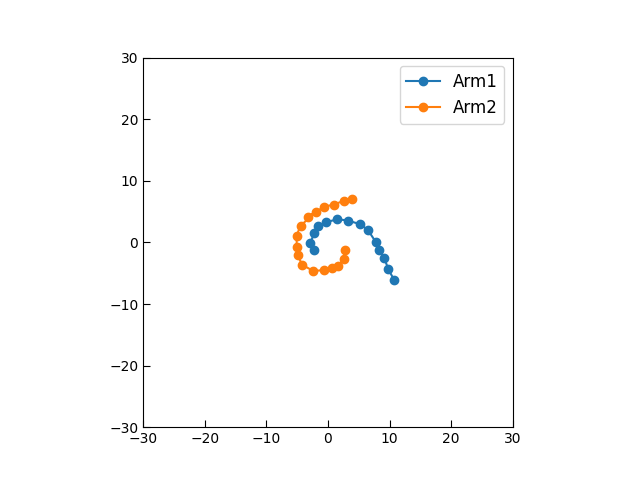

In [42]:
%matplotlib widget
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False

fig, ax = plt.subplots()
ax.plot(fits_arm1.x_tracing, fits_arm1.y_tracing, marker = 'o', label = 'Arm1')
ax.plot(fits_arm2.x_tracing, fits_arm2.y_tracing, marker = 'o', label = 'Arm2')
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.legend()
ax.set_aspect('equal')

In [26]:
def calc_euclidean(x1,y1,x2,y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [27]:
dist_previous = []
for i in range(len(df_tracing_arm2)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm2.iloc[i-1].x
        y1 = df_tracing_arm2.iloc[i-1].y
        
        x2 = df_tracing_arm2.iloc[i].x
        y2 = df_tracing_arm2.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))

In [28]:
df_tracing_arm2['dist_previous'] = dist_previous
df_tracing_arm2['arm_length'] = df_tracing_arm2.dist_previous.cumsum()



In [29]:
df_tracing_arm2.head(3)

,x,y,arm,id,dist_previous,arm_length
0,3.917749,7.007576,2,0,8.028379,8.028379
1,2.647908,6.776696,2,1,1.290660,9.319039
2,0.916306,6.141775,2,2,1.844334,11.163373


In [30]:
def assign_length(id_tracing, df_tracing):
    length = df_tracing[df_tracing.id == id_tracing].arm_length.values[0]
    return length

In [31]:
fits_arm2['arm_length'] = fits_arm2.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm2), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
fits_arm2.head(3)

,amplitude,center,delta,fractured,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,stderr_gamma,...,y,y_tracing,arm,r_tracing,width_info,x_max,y_max,w1,w2,arm_length
14,0.000064,7.595637,0.05,False,1.222636,0.0,0.716529,0.000009,0.542666,2.791414,...,"[8.758426699397312e-06, 1.78844827032675e-05, ...",7.007576,2,8.028379,"{'x_max': 7.977128017646488, 'y_max': 4.582015...",7.977128,0.000046,0.621894,0.679825,8.028379
15,0.000238,5.934664,0.05,False,4.086983,1.0,1.765205,0.000023,0.075682,1.605188,...,"[2.7939000447671148e-05, 2.8216246648892136e-0...",6.776696,2,7.275645,"{'x_max': 6.662380253996158, 'y_max': 9.422911...",6.662380,0.000094,0.794616,1.540035,9.319039
16,0.000104,6.707008,0.05,False,-2.949261,2.0,0.822144,0.000009,0.064025,1.893338,...,"[3.117555804778559e-05, 2.755359067852062e-05,...",6.141775,2,6.209752,"{'x_max': 6.315148932991168, 'y_max': 8.298992...",6.315149,0.000083,0.705002,0.453983,11.163373


In [33]:
fits_arm2.to_csv(f'DATA/results/Halo_{id_halo}_Arm2_widths_Oct10.csv')

In [34]:
fits_arm2[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
14,0.000064,7.595637,1.222636,0.0,0.716529,0.000009,0.542666,2,8.028379,0.621894,0.679825,8.028379
15,0.000238,5.934664,4.086983,1.0,1.765205,0.000023,0.075682,2,7.275645,0.794616,1.540035,9.319039
16,0.000104,6.707008,-2.949261,2.0,0.822144,0.000009,0.064025,2,6.209752,0.705002,0.453983,11.163373
17,0.000099,6.518918,-3.568668,3.0,0.873576,0.000006,0.042635,2,5.824846,0.754593,0.428750,12.703537
18,0.000145,5.394204,0.001973,4.0,0.713167,0.000016,159024.633764,2,5.323383,0.839560,0.839818,15.861304
19,0.000100,5.493339,0.005996,5.0,0.576389,0.000007,34430.033973,2,5.255040,0.678747,0.678531,17.358692
20,0.000141,5.951796,-2.049109,6.0,0.858396,0.000004,0.048415,2,5.225377,0.748246,0.583678,20.633001
21,0.000255,6.558943,-8.089708,7.0,2.306034,0.000018,0.057667,2,5.208454,2.178543,0.652373,22.369407
22,0.000333,6.343969,-7.319570,8.0,3.450505,0.000038,0.062925,2,5.146741,3.218048,1.047982,24.274168
23,0.000109,6.559235,-2.099326,9.0,0.932904,0.000004,0.057134,2,5.325651,0.811239,0.626110,25.555762


(-1.0, 1.0)

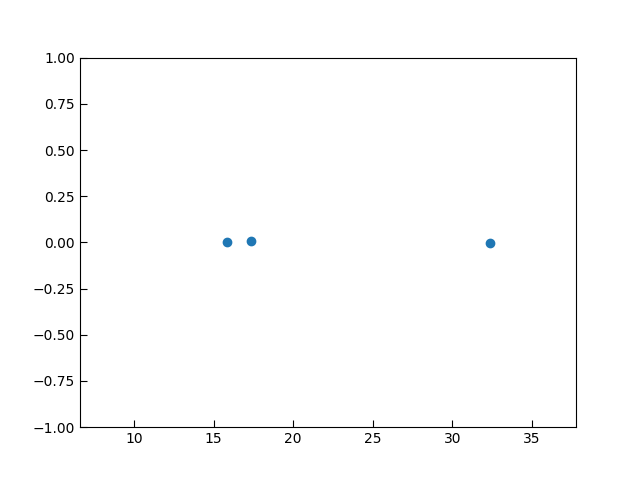

In [35]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm2.arm_length, fits_arm2.gamma)
ax.set_ylim(-1,1)

In [36]:
dist_previous = []
for i in range(len(df_tracing_arm1)):
    if i == 0:
        x1 = 0
        y1 = 0
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))
        
    else:
        x1 = df_tracing_arm1.iloc[i-1].x
        y1 = df_tracing_arm1.iloc[i-1].y
        
        x2 = df_tracing_arm1.iloc[i].x
        y2 = df_tracing_arm1.iloc[i].y
        
        dist_previous.append(calc_euclidean(x1,y1,x2,y2))


df_tracing_arm1['dist_previous'] = dist_previous
df_tracing_arm1['arm_length'] = df_tracing_arm1.dist_previous.cumsum()

In [37]:
fits_arm1['arm_length'] = fits_arm1.apply(lambda row: assign_length(row.id_tracing, df_tracing_arm1), axis = 1)

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
fits_arm1.to_csv(f'DATA/results/Halo_{id_halo}_Arm1_widths_Oct10.csv')

In [39]:
fits_arm1[['amplitude', 'center', 'gamma', 'id_tracing',
       'sigma', 'stderr_amplitude', 'stderr_center', 'arm', 'r_tracing', 'w1', 'w2', 'arm_length']]

,amplitude,center,gamma,id_tracing,sigma,stderr_amplitude,stderr_center,arm,r_tracing,w1,w2,arm_length
0,0.000203,12.463550,-2.815769,0.0,0.943725,0.000016,0.072555,1,12.339079,0.809435,0.535415,12.339079
1,0.000141,11.975673,-3.366697,1.0,1.562937,0.000020,0.178578,1,10.732195,1.345508,0.795904,14.301561
2,0.000130,8.261321,2.006645,2.0,1.549316,0.000016,0.253238,1,9.453575,1.064898,1.353957,16.274203
3,0.000152,7.897388,13.163369,3.0,1.869078,0.000021,0.039155,1,8.406247,0.369385,1.873554,17.730991
4,0.000135,7.338870,3.730706,4.0,1.011652,0.000011,0.057147,1,7.785028,0.482908,0.876246,19.156571
5,0.000083,6.883319,-2.837180,5.0,0.656595,0.000015,0.065348,1,6.773103,0.563264,0.370731,21.573932
6,0.000144,5.113400,2.476957,6.0,1.299634,0.000009,0.125052,1,5.976220,0.794686,1.117912,23.144088
7,0.000168,2.674620,4.289521,7.0,2.353237,0.000021,0.150712,1,4.792066,1.026920,2.061666,25.189692
8,0.000154,3.850712,-1.223236,8.0,1.369965,0.000014,0.685891,1,4.059938,1.300487,1.187969,26.936618
9,0.000162,2.606378,0.003659,9.0,1.113753,0.000009,61129.206318,1,3.269183,1.311008,1.311668,28.799823


(-1.0, 1.0)

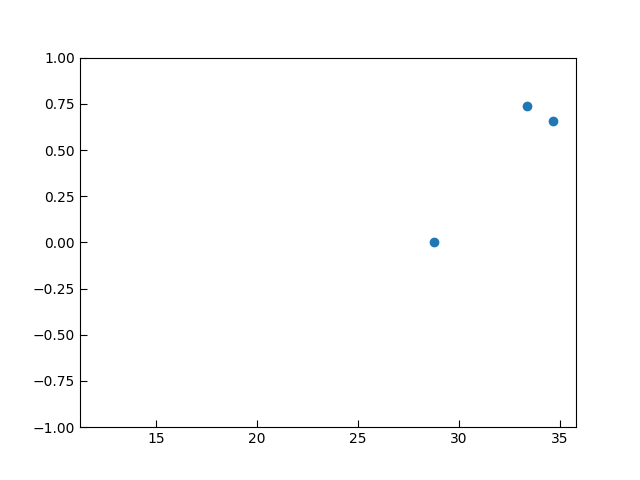

In [40]:
%matplotlib widget
fig,ax = plt.subplots()
ax.scatter(fits_arm1.arm_length, fits_arm1.gamma)
ax.set_ylim(-1,1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-bc0a71f77a6b>", line 2, in <module>
    ax.plot(arm1.x_tracing, arm1.y_tracing)
NameError: name 'arm1' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 1863, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/daniel

NameError: name 'arm1' is not defined

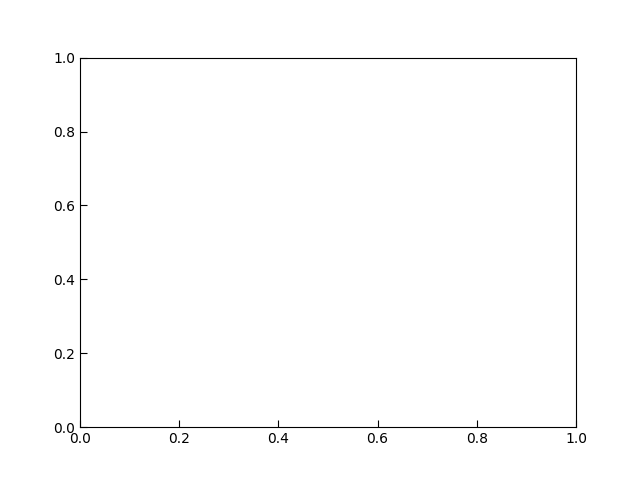

In [41]:
fig, ax = plt.subplots()
ax.plot(arm1.x_tracing, arm1.y_tracing)
ax.plot(arm2.x_tracing, arm2.y_tracing)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_aspect('equal')

In [ ]:
#df_fits.head
#print(df_fits["amplitude"], df_fits["center"], df_fits["sigma"],  df_fits["gamma"], df_fits["x_tracing"], df_fits["y_tracing"], df_fits["x_max"], df_fits["y_max"], df_fits["w1"], df_fits["w2"], df_fits["arm"], df_fits["fractured"])
#print(df_fits["w1"], df_fits["w2"])
#df_fits.to_csv('Arm_width_rho.csv')

In [ ]:
df_print = pd.DataFrame(zip(df_fits.amplitude, df_fits.center, df_fits.sigma, df_fits.gamma, df_fits.x_tracing, df_fits.y_tracing, df_fits.x_max, df_fits.y_max, df_fits.w1, df_fits.w2, df_fits.arm, df_fits.fractured, df_fits.id_tracing))


In [ ]:
df_print.to_csv('Arm2_widths_rho_adicionales_Ago4.csv')

In [ ]:
def find_widths_of_skewed_gaussian_dani(params, dx=0.001):
    # Evaluar el modelo ajustado
    fitted_model = eval_fitted_model_with_given_params(params, dx=dx)
    x_eval = fitted_model['x_eval']
    y_eval = fitted_model['y_eval']

    # Verificar que x_eval y y_eval no estén vacíos
    if len(x_eval) == 0 or len(y_eval) == 0:
        print(f"Advertencia: 'x_eval' o 'y_eval' están vacíos para params id: {params.get('id_tracing', 'desconocido')}")
        return {'x_max': np.nan, 'y_max': np.nan, 'w1': np.nan, 'w2': np.nan}

    # Continúa si no están vacíos
    x_max, y_max = find_maximum(x_eval, y_eval)

    xs_line = np.arange(np.min(x_eval), np.max(x_eval), 0.01)
    ys_line = np.full(len(xs_line), 0.5 * y_max)

    first_line = LineString(np.column_stack((x_eval, y_eval)))
    second_line = LineString(np.column_stack((xs_line, ys_line)))
    intersection = first_line.intersection(second_line)

    points_intercept = []
    if isinstance(intersection, MultiPoint):
        points_intercept = list(intersection)
    elif not intersection.is_empty:
        points_intercept = [intersection]

    points_intercept = [[point.x, point.y] for point in points_intercept]

    if len(points_intercept) >= 2:
        w1 = x_max - points_intercept[1][0]
        w2 = points_intercept[0][0] - x_max
    else:
        w1, w2 = np.nan, np.nan  # Si no hay suficientes intersecciones

    return {'x_max': x_max, 'y_max': y_max, 'w1': w1, 'w2': w2}



df_fits = pd.concat(dfs, axis = 0).reset_index(drop=True)
df_fits['r_tracing'] = np.sqrt(df_fits['x_tracing']**2 + df_fits['y_tracing']**2)
df_fits['width_info'] = df_fits.apply(lambda row: find_widths_of_skewed_gaussian_dani(row), axis = 1)
df_fits['x_max'] = df_fits.apply(lambda row: row.width_info['x_max'], axis = 1)
df_fits['y_max'] = df_fits.apply(lambda row: row.width_info['y_max'], axis = 1)
df_fits['w1'] = df_fits.apply(lambda row: row.width_info['w1'], axis = 1)
df_fits['w2'] = df_fits.apply(lambda row: row.width_info['w2'], axis = 1)